In [ ]:
'''
This code combines Allen summary data plus our own summary data
to compare the tuning properties of cells in the Brain Observatory
across Cre line, depth, and visual area
The code does logistic regression-based classification, PCA, and plots
group data in violin plots
'''

In [8]:
#load in dependencies and pick cells (can use get_good_cell_ids and save output)
drive_path = '/Volumes/Brain2016'
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import glob
from sklearn import preprocessing as prepro
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('notebook', font_scale=1)
import pickle

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
manifest_path = os.path.join(drive_path,'BrainObservatory','manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)

#manually load good cell ids from previously saved outputs of get_good_cell_ids
good_cell_ids = np.load('good_cell_ids.npy')
# good_cell_ids = np.load('good_cell_ids1p.npy')
# good_cell_ids = np.load('allAB_cell_ids.npy')
# good_cell_ids = np.load('noSBC_cell_ids.npy')

print("%d good cells for both stimuli"%len(good_cell_ids))

2896 good cells for both stimuli


In [9]:
#load drifting gratings circular variance measures from file
dcvdata = np.load('final_CV_dgs_0831_withPeaks.npy').T
dcolumns = ['cell_specimen_id','d_ocv','d_dcv','os_peak','ds_peak']
dCVdf = pd.DataFrame(data=dcvdata,columns=dcolumns)
dCV_ids = []
dCV_1 = []
dCV_2 = []
dCV_3 = []
dCV_4 = []
for row in range(len(dCVdf)):
    dCV_ids = np.hstack((dCV_ids,dCVdf.cell_specimen_id[row]))
    dCV_1 = np.hstack((dCV_1,dCVdf.d_ocv[row]))
    dCV_2 = np.hstack((dCV_2,dCVdf.d_dcv[row]))
    dCV_3 = np.hstack((dCV_3,dCVdf.os_peak[row]))
    dCV_4 = np.hstack((dCV_4,dCVdf.ds_peak[row]))
    
print('%d sessionA cells with drifting OCV/DCV measures'%len(dCV_ids))
print('%d data points with %d nan values'%(len(dCV_1),len(np.where(np.isnan(dCV_1)==True)[0])))
dcolumns = ['cell_specimen_id','dg_OriCircVar_MeanTF','dg_DirCircVar_MeanTF',\
            'dg_OriCircVar_MaxTF','dg_DirCircVar_MaxTF']
dcv_df_data = np.zeros(((len(dCV_ids),len(dcolumns))))              
dcv_df_data[:,0] = dCV_ids
dcv_df_data[:,1] = dCV_1
dcv_df_data[:,2] = dCV_2
dcv_df_data[:,3] = dCV_3
dcv_df_data[:,4] = dCV_3

dCVdf = pd.DataFrame(data=dcv_df_data,columns=dcolumns) 

#load static gratings circular variance
scvdata = np.load('final_CV_sgs_0831.npy').T
scolumns = ['cell_specimen_id','s_ocv_maxsf_maxphase','s_ocv_maxsf_mnphase',\
            's_ocv_mnsf_maxphase','s_ocv_mnsf_mnphase']
sCVdf = pd.DataFrame(data=scvdata,columns=scolumns)
sCV_ids = []
sCV_1 = []
sCV_2 = []
sCV_3 = []
sCV_4 = []
for row in range(len(sCVdf)):
    sCV_ids = np.hstack((sCV_ids,sCVdf.cell_specimen_id[row]))
    sCV_1 = np.hstack((sCV_1,sCVdf.s_ocv_maxsf_maxphase[row]))
    sCV_2 = np.hstack((sCV_2,sCVdf.s_ocv_maxsf_mnphase[row]))
    sCV_3 = np.hstack((sCV_3,sCVdf.s_ocv_mnsf_maxphase[row]))
    sCV_4 = np.hstack((sCV_4,sCVdf.s_ocv_mnsf_mnphase[row]))
print('%d sessionB cells with static OCV measures'%len(sCV_ids))
print('%d data points with %d nan values'%(len(sCV_1),len(np.where(np.isnan(sCV_1)==True)[0])))
scolumns = ['cell_specimen_id','sg_OriCircVar_MaxSF_MaxPhase','sg_OriCircVar_MaxSF_MeanPhase',\
            'sg_OriCircVar_MeanSF_MaxPhase','sg_OriCircVar_MeanSF_MeanPhase']
scv_df_data = np.zeros(((len(sCV_ids),5)))              
scv_df_data[:,0] = sCV_ids
scv_df_data[:,1] = sCV_1
scv_df_data[:,2] = sCV_2
scv_df_data[:,3] = sCV_3
scv_df_data[:,4] = sCV_4
sCVdf = pd.DataFrame(data=scv_df_data,columns=scolumns)

#make the combined CVdf
CVdf = dCVdf.merge(sCVdf,how='inner')

#get sf/tf index
sdf = pickle.load( open( "SGdf.p", "rb" ) )
ddf = pickle.load( open( "DGdf.p", "rb" ) )
SGdf = pd.DataFrame(sdf)
DGdf = pd.DataFrame(ddf)
SDdf = DGdf.merge(SGdf)
# #get sf/tf index
# sdf = pickle.load( open( "allSFcells_divByMean.p", "rb" ) )
# SDdf = pd.DataFrame(sdf)

#merge w/OCV data
custdf = CVdf.merge(SDdf)

#get the pre-analyzed data for "good cells"
cell_df = pd.DataFrame(boc.get_cell_specimens(ids=good_cell_ids))
print("%d good cells with pre-analyzed data"%len(cell_df))
precolumns = ['dsi_dg','osi_dg','osi_sg','pref_sf_sg','pref_tf_dg',\
                 'time_to_peak_ns','time_to_peak_sg','cell_specimen_id',\
              'area','tld1_name','imaging_depth']
pre_df = cell_df[precolumns]

good_df = custdf.merge(pre_df,how='inner')

#get rid of cells with any nan values
nan_inds = []
for key in range(len(good_df.keys())-4):
    nan_inds = np.hstack((nan_inds,np.where(np.isnan(good_df[good_df.keys()[key]]))[0]))
nan_inds = np.unique(nan_inds).astype('int')
        
all_inds = np.asarray(range(len(good_df)))

not_nan_inds = []
for ind in all_inds: 
    if ind in nan_inds: 
        pass
    else: 
        not_nan_inds.append(int(ind))
        
print('%d total cells, %d with nan values, %d good cells'%(len(all_inds),len(nan_inds),len(not_nan_inds)))
good_df = good_df.iloc[not_nan_inds]

12739 sessionA cells with drifting OCV/DCV measures
12739 data points with 718 nan values
11983 sessionB cells with static OCV measures
11983 data points with 0 nan values
2896 good cells with pre-analyzed data
2896 total cells, 119 with nan values, 2777 good cells


In [10]:
##Select measures for PCA and classification (key number corresponds to columns in the scaled_df Pandas DF)
scaled_df = good_df#[good_df.area==PCA_area]
PCA_keys = scaled_df.keys()[np.array([3,4,5,22,23,25])]
PCA_df = scaled_df[PCA_keys]
data_scaled=np.zeros((len(PCA_df),len(PCA_keys)))
print('%d total cells for PCA'%len(PCA_df))

#scale the data to be mean 0 and variance 1
for i in range(data_scaled.shape[1]):
    data_scaled[:,i] = prepro.scale(PCA_df[PCA_keys[i]])

#make arrays with matching cell ids, area, depth, and cre line for each cell
cs_ids_scaled = scaled_df.cell_specimen_id.values
areas_scaled = scaled_df.area.values
depths_scaled = scaled_df.imaging_depth.values
cre_scaled = scaled_df.tld1_name.values

areas_color_scaled=np.zeros((len(PCA_df),1))
cnt=1
for area in np.unique(areas_scaled):
    areas_color_scaled[areas_scaled==area] = cnt
    cnt+=1
    
depths_color_scaled=np.zeros((len(PCA_df),1))
cnt=1
for depth in np.unique(depths_scaled):
    depths_color_scaled[depths_scaled==depth] = cnt
    cnt+=1
    
cre_color_scaled=np.zeros((len(PCA_df),1))
cnt=1
for cre in np.unique(cre_scaled):
    cre_color_scaled[cre_scaled==cre] = cnt
    cnt+=1

ven_dors = np.zeros((len(PCA_df),1))
for i in range(len(ven_dors)):
    if (areas_scaled[i]=='VISp')|(areas_scaled[i]=='VISl'):
        ven_dors[i] = 1
    else:
        ven_dors[i] = 2

2777 total cells for PCA


In [11]:
#try to classify V1 cells by cre line
y = cre_color_scaled.ravel()
X = data_scaled
z = cre_color_scaled.ravel()

# print y
# area_counts = []
# for area in np.unique(good_df.area):
#     area_counts = np.append(area_counts,len(good_df[(good_df.area==area)]))
#     np.random.choice(rand_set,5)

#pick only cells in the area
X = X[areas_color_scaled.ravel()==3,:]
y = y[areas_color_scaled.ravel()==3]
z = z[areas_color_scaled.ravel()==3]

#exclude Scnn1
X = X[z!=4,:]
y = y[z!=4]


area_counts=[]
for area in np.unique(y):
    area_counts = np.append(area_counts,np.asarray(np.where(y==area)).shape[1])


conf_mtx = np.zeros((len(np.unique(y)),len(np.unique(y))))
coeffs = np.zeros((len(np.unique(y)),X.shape[1]))
train_score = []
test_score = []
for k in range(100):
    for area in np.unique(y):    
        inds = np.random.permutation(np.where(y==area)[0])
        train_inds = inds[:np.floor(0.8*int(area_counts.min()))]
        test_inds = inds[-np.floor(0.2*int(area_counts.min())):]
#         print('Shape and max of inds,train_inds,test_inds for %s',np.unique(good_df.tld1_name)[area-1])
#         print inds.shape,train_inds.shape,test_inds.shape,inds.max(),train_inds.max(),test_inds.max()
        if area==1:
            X_train = X[train_inds,:]
            y_train = y[train_inds]
            X_test = X[test_inds,:]
            y_test = y[test_inds]
        else:
            X_train = np.vstack((X_train,X[train_inds,:]))
            y_train = np.hstack((y_train,y[train_inds]))
            X_test = np.vstack((X_test,X[test_inds,:]))
            y_test = np.hstack((y_test,y[test_inds]))

#     print('shape of training and test X,y:')
#     print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

    from sklearn.cross_validation import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score as score
    from sklearn.metrics import confusion_matrix as cm
    # from sklearn import svm



    # X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2)
    est = LogisticRegression(C=1, penalty='l2')
    # est = svm.SVC()
    est.fit(X_train,y_train)
    y_train_pred = est.predict(X_train)
#     print "training score: %f" % score(y_train_pred, y_train)
    y_test_pred = est.predict(X_test)
#     print "testing score: %f" % score(y_test_pred, y_test)
#     print "confusion matrix train:"
#     print(cm(y_train, y_train_pred))
#     print "confusion matrix test:"
#     print('Ventral,Dorsal streams')
#     print(cm(y_test, y_test_pred))
#     print(est.coef_)
#     print(PCA_keys)

    conf_mtx += cm(y_test, y_test_pred)
    train_score.append(score(y_train_pred, y_train))
    test_score.append(score(y_test_pred, y_test))
    coeffs += est.coef_

V1cre_conf = conf_mtx/100
V1cre_conf = V1cre_conf/len(test_inds)
V1cre_coeffs = coeffs/100
V1cre_train = train_score
V1cre_test = test_score
print(V1cre_conf)
print(V1cre_coeffs)
print(np.unique(cre_scaled)[[0,1,2]])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[ 0.37567568  0.31567568  0.30864865]
 [ 0.27297297  0.50810811  0.21891892]
 [ 0.37        0.32513514  0.30486486]]
[[ 0.05914271  0.05914271  0.21127685 -0.1786696  -0.02875652 -0.27879765]
 [-0.14996487 -0.14996487 -0.117798    0.26136389  0.14556842  0.36814693]
 [ 0.07605171  0.07605171 -0.10497609 -0.13405573 -0.13070791 -0.14679105]]
[u'Cux2-CreERT2' u'Rbp4-Cre' u'Rorb-IRES2-Cre']


In [12]:
#try to classify V1 cells by depth
y = depths_color_scaled.ravel()
X = data_scaled
z = cre_color_scaled.ravel()
# print y
# area_counts = []
# for area in np.unique(good_df.area):
#     area_counts = np.append(area_counts,len(good_df[(good_df.area==area)]))
#     np.random.choice(rand_set,5)

#pick only cells in the area
X = X[areas_color_scaled.ravel()==3,:]
y = y[areas_color_scaled.ravel()==3]
z = z[areas_color_scaled.ravel()==3]

#exclude Scnn1
X = X[z!=4,:]
y = y[z!=4]

area_counts=[]
for area in np.unique(y):
    area_counts = np.append(area_counts,np.asarray(np.where(y==area)).shape[1])
    
conf_mtx = np.zeros((len(np.unique(y)),len(np.unique(y))))
coeffs = np.zeros((len(np.unique(y)),X.shape[1]))
train_score = []
test_score = []
for k in range(100):
    for area in np.unique(y):    
        inds = np.random.permutation(np.where(y==area)[0])
        train_inds = inds[:np.floor(0.8*int(area_counts.min()))]
        test_inds = inds[-np.floor(0.2*int(area_counts.min())):]
#         print('Shape and max of inds,train_inds,test_inds for %s',np.unique(good_df.tld1_name)[area-1])
#         print inds.shape,train_inds.shape,test_inds.shape,inds.max(),train_inds.max(),test_inds.max()
        if area==1:
            X_train = X[train_inds,:]
            y_train = y[train_inds]
            X_test = X[test_inds,:]
            y_test = y[test_inds]
        else:
            X_train = np.vstack((X_train,X[train_inds,:]))
            y_train = np.hstack((y_train,y[train_inds]))
            X_test = np.vstack((X_test,X[test_inds,:]))
            y_test = np.hstack((y_test,y[test_inds]))

#     print('shape of training and test X,y:')
#     print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

    from sklearn.cross_validation import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score as score
    from sklearn.metrics import confusion_matrix as cm
    # from sklearn import svm



    # X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2)
    est = LogisticRegression(C=1, penalty='l2')
    # est = svm.SVC()
    est.fit(X_train,y_train)
    y_train_pred = est.predict(X_train)
#     print "training score: %f" % score(y_train_pred, y_train)
    y_test_pred = est.predict(X_test)
#     print "testing score: %f" % score(y_test_pred, y_test)
#     print "confusion matrix train:"
#     print(cm(y_train, y_train_pred))
#     print "confusion matrix test:"
#     print('Ventral,Dorsal streams')
#     print(cm(y_test, y_test_pred))
#     print(est.coef_)
#     print(PCA_keys)

    conf_mtx += cm(y_test, y_test_pred)
    train_score.append(score(y_train_pred, y_train))
    test_score.append(score(y_test_pred, y_test))
    coeffs += est.coef_

V1depth_conf = conf_mtx/100
V1depth_conf = V1depth_conf/len(test_inds)
V1depth_coeffs = coeffs/100
V1depth_train = train_score
V1depth_test = test_score
print(V1depth_conf)
print(V1depth_coeffs)
print(np.unique(depths_scaled)[[0,1,3]])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[ 0.52621622  0.23216216  0.24162162]
 [ 0.29648649  0.48189189  0.22162162]
 [ 0.35621622  0.24864865  0.39513514]]
[[ 0.02562569  0.02562569  0.10534827 -0.07811947 -0.49263811  0.11437121]
 [ 0.10373546  0.10373546  0.04557511 -0.27452648  0.22377031 -0.75194855]
 [-0.13991833 -0.13991833 -0.16882477  0.27276334  0.16429719  0.43750717]]
[175 275 375]


In [13]:
#try to classify based on ventral/dorsal stream
y = ven_dors.ravel()
X = data_scaled
z = areas_color_scaled.ravel()
zzz = cre_color_scaled.ravel()

# print y
# area_counts = []
# for area in np.unique(good_df.area):
#     area_counts = np.append(area_counts,len(good_df[(good_df.area==area)]))
#     np.random.choice(rand_set,5)

#if excluding a cre line
X = X[cre_color_scaled.ravel()!=4,:]
y = y[cre_color_scaled.ravel()!=4]
z = z[cre_color_scaled.ravel()!=4]

#exclude Scnn1
X = X[z!=4,:]
y = y[z!=4]

area_counts=[]
for area in np.unique(z):
#     area_counts = np.append(area_counts,len(good_df[(good_df.area==area)&(good_df.tld1_name!='Scnn1a-Tg3-Cre')]))
    area_counts = np.append(area_counts,np.asarray(np.where(z==area)).shape[1])
area_counts = np.asarray([area_counts[1]+area_counts[2],area_counts[0]+area_counts[3]])


conf_mtx = np.zeros((len(np.unique(y)),len(np.unique(y))))
coeffs = np.zeros((len(np.unique(y)),X.shape[1]))
train_score = []
test_score = []
for k in range(100):
    for area in np.unique(y):    
        inds = np.random.permutation(np.where(y==area)[0])
        train_inds = inds[:np.floor(0.8*int(area_counts.min()))]
        test_inds = inds[-np.floor(0.2*int(area_counts.min())):]
    #     print('Shape and max of inds,train_inds,test_inds for %s',np.unique(good_df.area)[area-1])
    #     print inds.shape,train_inds.shape,test_inds.shape,inds.max(),train_inds.max(),test_inds.max()
        if area==1:
            X_train = X[train_inds,:]
            y_train = y[train_inds]
            X_test = X[test_inds,:]
            y_test = y[test_inds]
        else:
            X_train = np.vstack((X_train,X[train_inds,:]))
            y_train = np.hstack((y_train,y[train_inds]))
            X_test = np.vstack((X_test,X[test_inds,:]))
            y_test = np.hstack((y_test,y[test_inds]))

    # print('shape of training and test X,y:')
    # print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

    from sklearn.cross_validation import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score as score
    from sklearn.metrics import confusion_matrix as cm
    # from sklearn import svm



    # X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2)
    est = LogisticRegression(C=1, penalty='l2')
    # est = svm.SVC()
    est.fit(X_train,y_train)
    y_train_pred = est.predict(X_train)
    # print "training score: %f" % score(y_train_pred, y_train)
    y_test_pred = est.predict(X_test)
    # print "testing score: %f" % score(y_test_pred, y_test)
    # print "confusion matrix train:"
    # print(cm(y_train, y_train_pred))
    # print "confusion matrix test:"
    # print('Ventral,Dorsal streams')
    # print(cm(y_test, y_test_pred))
    # print(est.coef_)
    # print(PCA_keys)

    conf_mtx += cm(y_test, y_test_pred)
    train_score.append(score(y_train_pred, y_train))
    test_score.append(score(y_test_pred, y_test))
    coeffs += est.coef_

DorVen_conf = conf_mtx/100
DorVen_conf = DorVen_conf/len(test_inds)
DorVen_coeffs = coeffs/100
DorVen_train = train_score
DorVen_test = test_score
print(DorVen_conf)
print(DorVen_coeffs)
print('Dorsal,Ventral streams')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[ 0.82572165  0.17427835]
 [ 0.74690722  0.25309278]]
[[-0.02273319 -0.02273319  0.01354701  0.12185588  0.22995084  0.08578181]
 [-0.02273319 -0.02273319  0.01354701  0.12185588  0.22995084  0.08578181]]
Dorsal,Ventral streams


In [14]:
#try to classify based on area
y = areas_color_scaled.ravel()
X = data_scaled
# print y
# area_counts = []
# for area in np.unique(good_df.area):
#     area_counts = np.append(area_counts,len(good_df[(good_df.area==area)]))
#     np.random.choice(rand_set,5)

#if excluding a cre line
X = X[cre_color_scaled.ravel()!=4,:]
y = y[cre_color_scaled.ravel()!=4]

area_counts=[]
for area in np.unique(y):
#     area_counts = np.append(area_counts,len(good_df[(good_df.area==area)&(good_df.tld1_name!='Scnn1a-Tg3-Cre')]))
    area_counts = np.append(area_counts,np.asarray(np.where(y==area)).shape[1])

conf_mtx = np.zeros((len(np.unique(y)),len(np.unique(y))))
coeffs = np.zeros((len(np.unique(y)),X.shape[1]))
train_score = []
test_score = []
for k in range(100):
    for area in np.unique(y):    
        inds = np.random.permutation(np.where(y==area)[0])
        train_inds = inds[:np.floor(0.8*int(area_counts.min()))]
        test_inds = inds[-np.floor(0.2*int(area_counts.min())):]
#         print('Shape and max of inds,train_inds,test_inds for %s',np.unique(good_df.area)[area-1])
#         print inds.shape,train_inds.shape,test_inds.shape,inds.max(),train_inds.max(),test_inds.max()
        if area==1:
            X_train = X[train_inds,:]
            y_train = y[train_inds]
            X_test = X[test_inds,:]
            y_test = y[test_inds]
        else:
            X_train = np.vstack((X_train,X[train_inds,:]))
            y_train = np.hstack((y_train,y[train_inds]))
            X_test = np.vstack((X_test,X[test_inds,:]))
            y_test = np.hstack((y_test,y[test_inds]))

#     print('shape of training and test X,y:')
#     print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

    from sklearn.cross_validation import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score as score
    from sklearn.metrics import confusion_matrix as cm
    # from sklearn import svm



    # X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2)
    est = LogisticRegression(C=1, penalty='l2')
    # est = svm.SVC()
    est.fit(X_train,y_train)
    y_train_pred = est.predict(X_train)
#     print "training score: %f" % score(y_train_pred, y_train)
    y_test_pred = est.predict(X_test)
#     print "testing score: %f" % score(y_test_pred, y_test)
#     print "confusion matrix train:"
#     print(cm(y_train, y_train_pred))
#     print "confusion matrix test:"
#     print(np.unique(good_df.area))
#     print(cm(y_test, y_test_pred))
#     print(est.coef_)
#     print(PCA_keys)

    conf_mtx += cm(y_test, y_test_pred)
    train_score.append(score(y_train_pred, y_train))
    test_score.append(score(y_test_pred, y_test))
    coeffs += est.coef_

areas_conf = conf_mtx/100
areas_conf = areas_conf/len(test_inds)
areas_coeffs = coeffs/100
areas_train = train_score
areas_test = test_score
print(areas_conf)
print(areas_coeffs)
print(np.unique(areas_scaled))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[ 0.18926471  0.19205882  0.35764706  0.26102941]
 [ 0.13735294  0.24044118  0.39102941  0.23117647]
 [ 0.14426471  0.25573529  0.47544118  0.12455882]
 [ 0.18470588  0.18485294  0.28588235  0.34455882]]
[[-0.02754684 -0.02754684  0.00787579  0.0514275   0.13904494 -0.09129999]
 [-0.05003693 -0.05003693 -0.05176192 -0.03411965 -0.14071097 -0.04468121]
 [ 0.03610092  0.03610092  0.04041337 -0.17895289 -0.1729881  -0.34547942]
 [ 0.04323853  0.04323853  0.00447575  0.11413754  0.13438295  0.33827488]]
[u'VISal' u'VISl' u'VISp' u'VISpm']


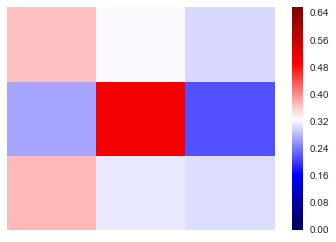

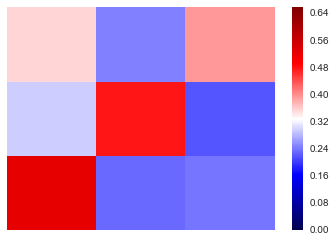

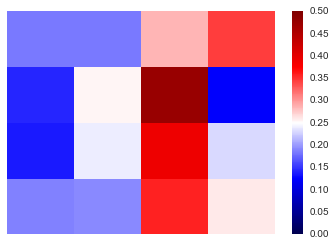

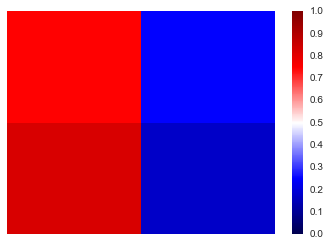

In [15]:
#plot and save confusion matrices for classification
#note that it flips y axis so labels are backwards in y dimension
plt.figure()
fig, ax = plt.subplots(1,1,figsize=(6,4))
heatmap = ax.pcolor(V1cre_conf,cmap='seismic',vmin=0, vmax=0.66)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.colorbar(heatmap)
plt.savefig('V1cre_conf.png')

plt.figure()
fig, ax = plt.subplots(1,1,figsize=(6,4))
heatmap = ax.pcolor(V1depth_conf,cmap='seismic',vmin=0, vmax=0.66)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.colorbar(heatmap)
plt.savefig('V1depth_conf.png')

plt.figure()
fig, ax = plt.subplots(1,1,figsize=(6,4))
heatmap = ax.pcolor(areas_conf,cmap='seismic',vmin=0, vmax=0.5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.colorbar(heatmap)
plt.savefig('areas_conf.png')

plt.figure()
fig, ax = plt.subplots(1,1,figsize=(6,4))
heatmap = ax.pcolor(DorVen_conf,cmap='seismic',vmin=0, vmax=1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.colorbar(heatmap)
plt.savefig('DorVen_conf.png')

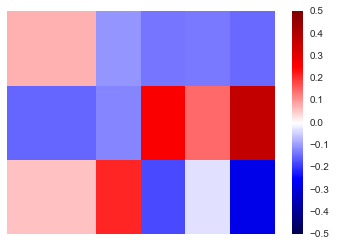

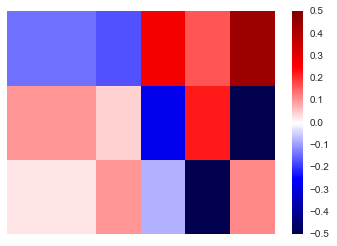

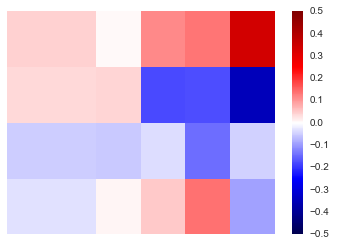

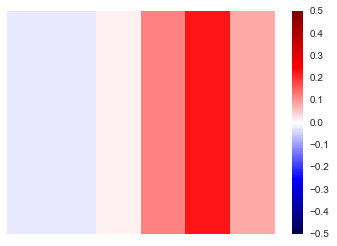

In [16]:
#plot and save figures for coefficients from logistic regression in classification
#note that it flips the y axis so labels are backwards in y dimension
plots = [V1cre_coeffs,V1depth_coeffs,areas_coeffs,DorVen_coeffs]
file_labels = ['V1cre_coeffs.png','V1depth_coeffs.png','areas_coeffs.png','DorVen_coeffs.png']

for i in range(len(plots)):
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    heatmap = ax.pcolor(plots[i],cmap='seismic',vmin=-0.5, vmax=0.5)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.colorbar(heatmap)
    plt.savefig(file_labels[i])



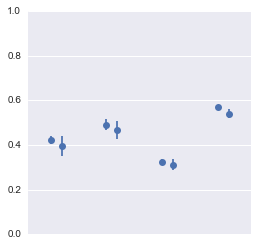

In [17]:
#plot success of classifier for cre line, depth, area, and dorsal/ventral stream
mean_std_list = np.asarray([V1cre_train,V1cre_test,V1depth_train,V1depth_test,\
                            areas_train,areas_test,DorVen_train,DorVen_test])
mean_list=[]
std_list=[]
for i in mean_std_list:
    mean_list.append(i.mean())
    std_list.append(np.std(i))

plt.figure()
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.errorbar([0.8,1.2,2.8,3.2,4.8,5.2,6.8,7.2],mean_list,std_list,fmt='o')
ax.set_xlim([0,8])
ax.set_ylim([0,1])
ax.xaxis.set_visible(False)
plt.savefig('classification_scores.png')


Index([         u'dg_OriCircVar_MaxTF',          u'dg_DirCircVar_MaxTF',
       u'sg_OriCircVar_MaxSF_MaxPhase',                   u'pref_sf_sg',
                         u'pref_tf_dg',              u'time_to_peak_sg'],
      dtype='object')
Components [[ 0.70060011  0.70060011 -0.11131599 -0.04737321  0.02242732 -0.05639608]
 [-0.01407857 -0.01407857  0.38577284 -0.63790365 -0.17177258 -0.64370492]]
Explained variance [ 0.33645995  0.18641463]
Singluar values: [ 2.01875971  1.11848776]


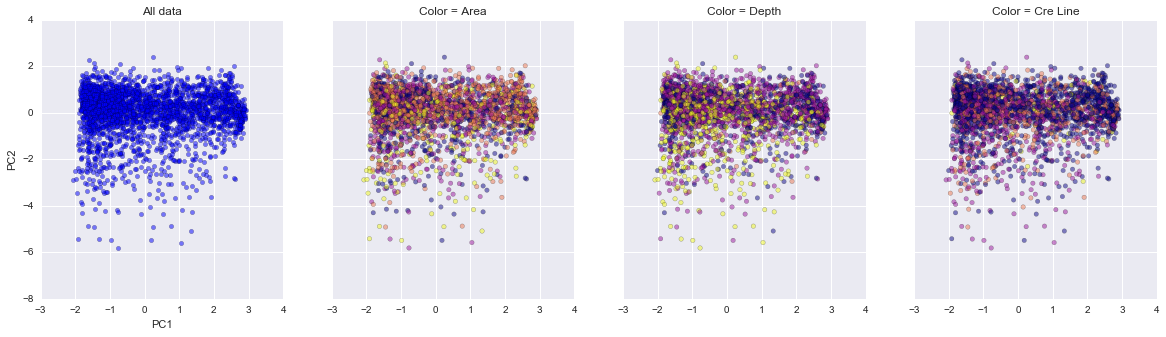

In [18]:
#run PCA and show the first two components
pca = PCA(n_components=2)
y=pca.fit_transform(data_scaled)
print(str(PCA_keys))
print 'Components',pca.components_
print 'Explained variance',pca.explained_variance_ratio_
print 'Singluar values:',pca.explained_variance_

fig,ax=plt.subplots(1,4,figsize=(20,5),sharex=True,sharey=True)
ax[0].scatter(y[:,0],y[:,1],alpha=0.5)
ax[1].scatter(y[:,0],y[:,1],c=areas_color_scaled,alpha=0.5,cmap='plasma')
ax[2].scatter(y[:,0],y[:,1],c=depths_color_scaled,alpha=0.5,cmap='plasma')
ax[3].scatter(y[:,0],y[:,1],c=cre_color_scaled,alpha=0.5,cmap='plasma')
ax[0].set_title('All data')
ax[1].set_title('Color = Area')
ax[2].set_title('Color = Depth')
ax[3].set_title('Color = Cre Line')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

plt.savefig('PC2.png')

Index([         u'dg_OriCircVar_MaxTF',          u'dg_DirCircVar_MaxTF',
       u'sg_OriCircVar_MaxSF_MaxPhase',                   u'pref_sf_sg',
                         u'pref_tf_dg',              u'time_to_peak_sg'],
      dtype='object')
Components [[ 0.70060011  0.70060011 -0.11131599 -0.04737321  0.02242732 -0.05639608]
 [-0.01407857 -0.01407857  0.38577284 -0.63790365 -0.17177258 -0.64370492]
 [ 0.07212272  0.07212272  0.51268885  0.24394616 -0.77154688  0.26823955]]
Explained variance [ 0.33645995  0.18641463  0.17292704]
Singluar values: [ 2.01875971  1.11848776  1.03756223]


//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


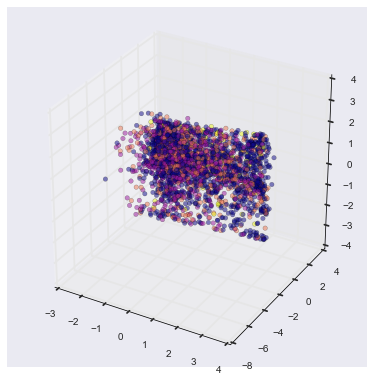

In [19]:
#run PCA and show first three components
pca = PCA(n_components=3)
y=pca.fit_transform(data_scaled)
y.shape
print(str(PCA_keys))
print 'Components',pca.components_
print 'Explained variance',pca.explained_variance_ratio_
print 'Singluar values:',pca.explained_variance_
# colors= ['r',areas_color_scaled,depths_color_scaled,cre_color_scaled]
colors= [cre_color_scaled]
plt.figure()
for i in range(len(colors)):
    fig,ax=plt.subplots(1,1,figsize=(5,5),sharex=True,sharey=True)
    ax=Axes3D(fig)
    ax.scatter(y[:,0],y[:,1],y[:,2],c=colors[i],alpha=0.5,cmap='plasma')
# #### ax=ax.ravel()
    
plt.tight_layout()
plt.savefig('PC3_cre.png')

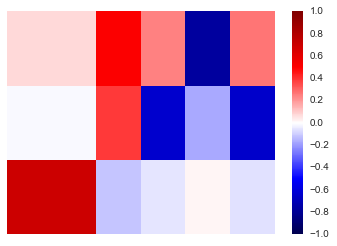

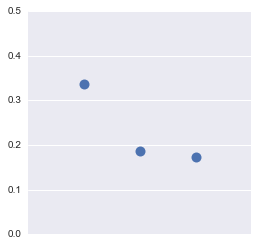

In [20]:
#plot the components and explained variance of PCA
plt.figure()
fig, ax = plt.subplots(1,1,figsize=(6,4))
heatmap = ax.pcolor(pca.components_,cmap='seismic',vmin=-1, vmax=1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.colorbar(heatmap)
plt.savefig('PCA_comp.png')

plt.figure()
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot([1,2,3],pca.explained_variance_ratio_,'.',markersize=20)
ax.set_xlim([0,4])
ax.set_ylim([0,0.5])
ax.xaxis.set_visible(False)

plt.savefig('PCA_ev.png')



There are 630 total cells in VISal
There are 790 total cells in VISl
There are 1013 total cells in VISp
There are 344 total cells in VISpm
There are 2777 total cells


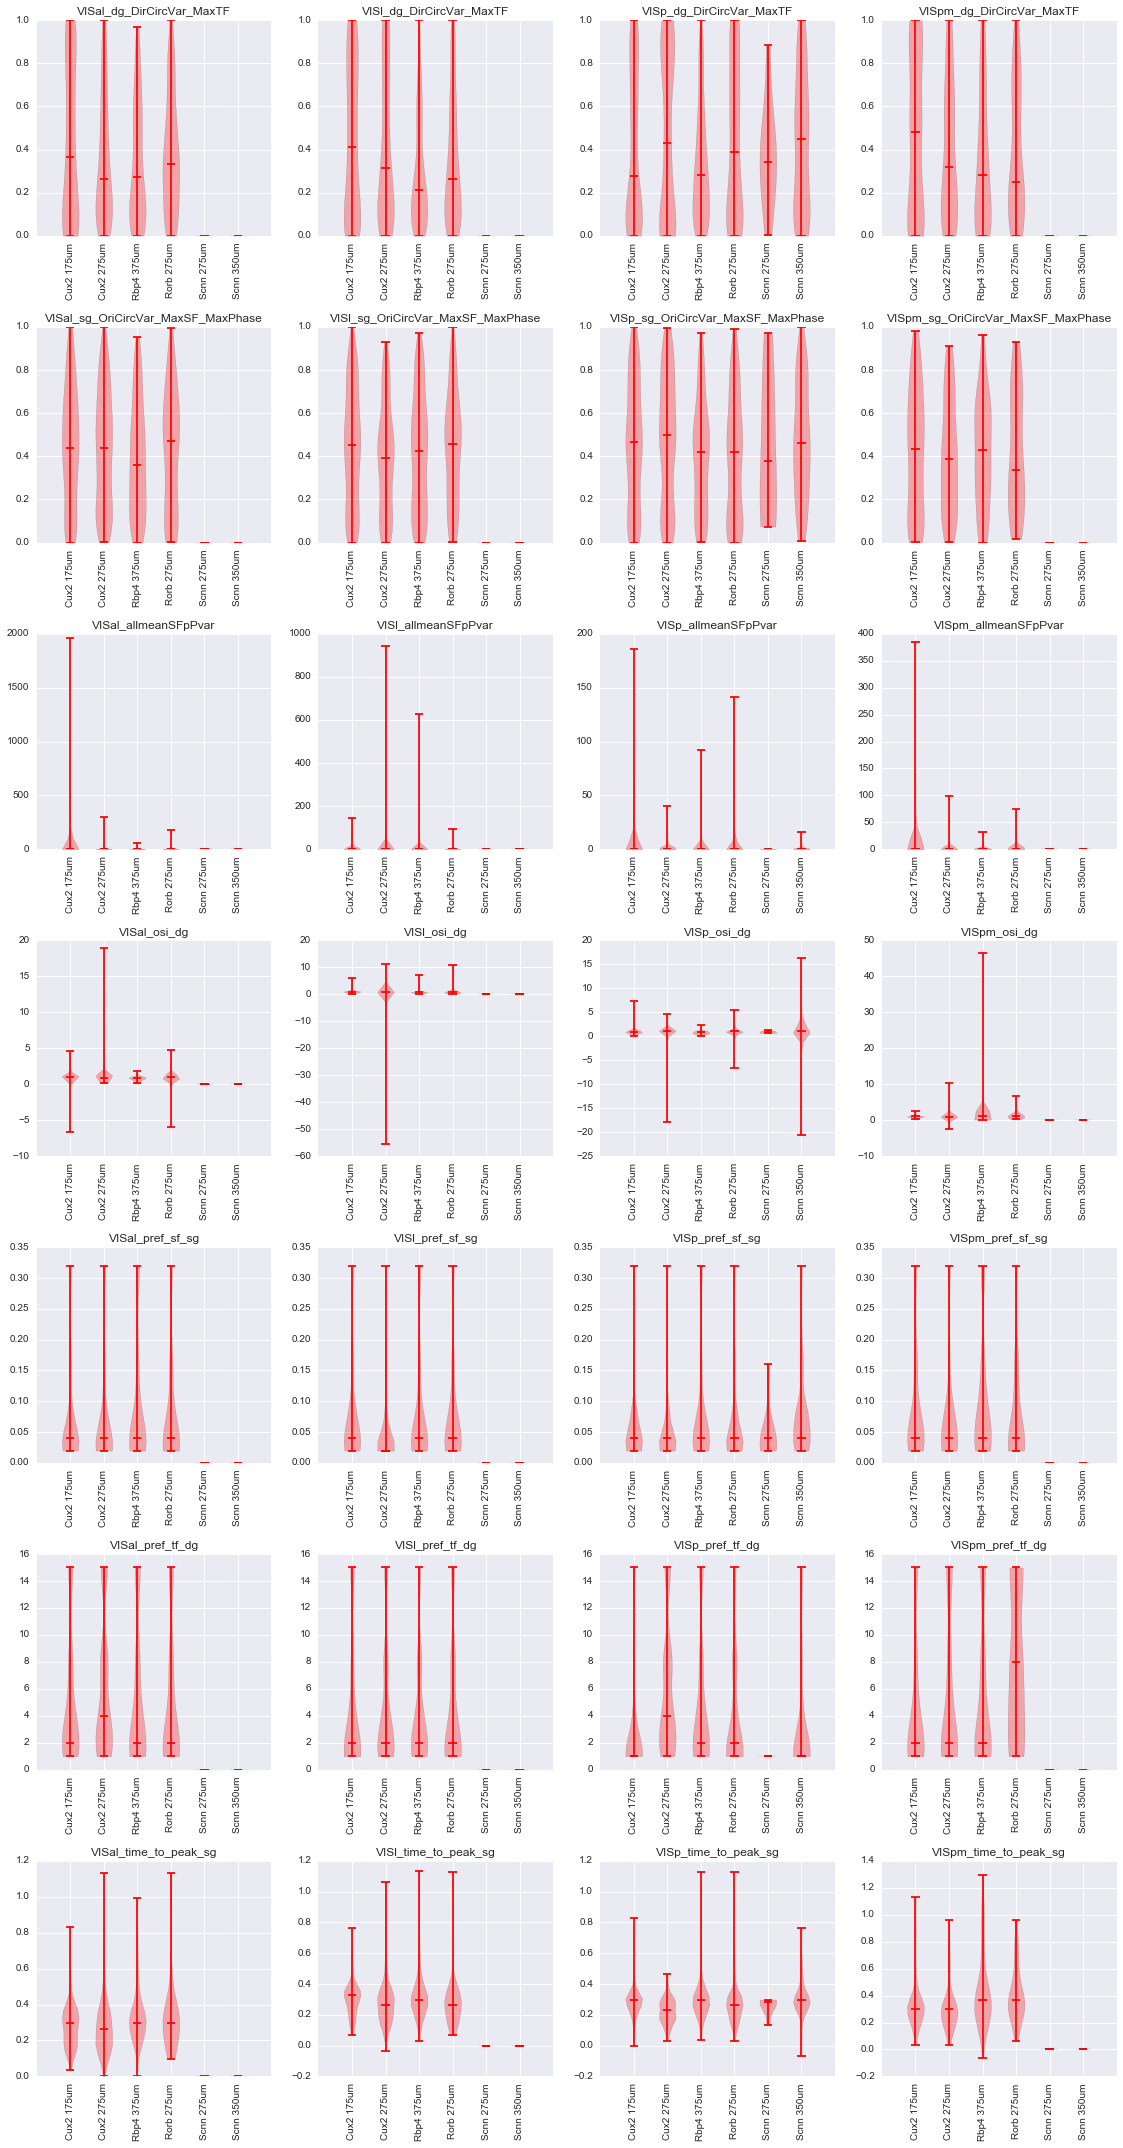

In [21]:
#make violin plots to show group data
plot_keys = good_df.keys()[np.array([3,4,5,12,20,22,23,25,26,27,28])]
plot_df = good_df[plot_keys]

#create a pandas table where each index contains all of the values for individual cells in that cre line/depth for OSI, DSI, etc.
#create list of conditions based available data for cre line and depth
depth_handles = plot_df.imaging_depth.unique()
depth_handles.sort()
cre_handles = plot_df.tld1_name.unique()
cre_handles.sort()
conditions=[]
for line in cre_handles:
        for depth in depth_handles:
            if np.isnan(plot_df[(plot_df.tld1_name==line)&(plot_df.imaging_depth==depth)].mean().values[0]):
                continue
            else:
                tup = (str(line),int(float(depth)))
                conditions.append(tup)
xlabels = []
for i in range(len(conditions)):
    xlabels.append("%s %sum"%(conditions[i][0][:4],str(conditions[i][1])))
columns = plot_keys
all_data = pd.DataFrame(data=[],columns=columns,index=xlabels)
# reject_data = pd.DataFrame(data=[],columns=columns,index=xlabels)
cnt=0
total_cells=0
# total_reject_cells=0

#create violin plots showing the distributions of the measured properties of the cells
fig = plt.figure()
titles = all_data.keys()[1:-3]
pos = [1,2,3,4,5,6]
areas = np.unique(plot_df.area)
fig,ax = plt.subplots(len(titles),4,figsize=(16,30))#,sharex=True)
ax = ax.ravel()
# gs = gridspec.GridSpec(len(titles),len(areas))
area_cells = []
itr = np.arange(0,len(titles)*len(areas),4)
for area in range(len(areas)):
    total_cells=0
    for cond in range(len(xlabels)):
        for key in range(len(columns)):
            data = plot_df[(plot_df.area==areas[area])&\
                           (plot_df.tld1_name==conditions[cond][0])&\
                           (plot_df.imaging_depth==int(float(conditions[cond][1])))]
            if data.empty:
                all_data.loc[xlabels[cond],columns[key]] = np.zeros((1,6))
            else:
                all_data.loc[xlabels[cond],columns[key]] = data[data.keys()[key]].values
        total_cells += len(data)
    area_cells = np.hstack((area_cells,total_cells))
    for i in itr:
#             ax[i+area] = plt.subplot(gs[i,area])
        vplot = ax[i+area].violinplot(all_data.loc[xlabels,titles[np.where(itr==i)[0][0]]].values\
                              ,pos, points=20, widths=0.5, showextrema=True, showmedians=True)
        ax[i+area].set_title(str(areas[area])+'_'+str(titles[np.where(itr==i)[0][0]]))
        ax[i+area].set_xlim([0,len(conditions)+1])
        ax[i+area].set_xticks(np.arange(len(conditions))+1)
        ax[i+area].set_xticklabels(xlabels,rotation="vertical")
        for pc in vplot['bodies']:
            pc.set_facecolor('red')
#             pc.set_edgecolor('green')
plt.tight_layout()
for n in range(len(areas)):
    print('There are %d total cells in %s'%(area_cells[n],areas[n]))
print('There are %d total cells'%area_cells.sum())
plt.savefig('visarea_cre_depth_summary.png')

In [ ]:
#everything below this cell is old code, mostly doing calculations on the mean/SEM
#this can now be done more efficiently with the code above

In [ ]:
# # columns_scaled = good_df.keys()
# # good_df_scaled = good_df[(cell_df.area=='VISp')]
# # data_scaled=np.zeros((len(good_df_scaled),len(columns_scaled)-5))
# # for i in range(data_scaled.shape[1]):
# #     data_scaled[:,i] = prepro.scale(cell_df_PCA[columns_scaled[i]])

# cs_ids_scaled = cell_df_PCA.cell_specimen_id.values
# areas_scaled = cell_df_PCA.area.values
# depths_scaled = cell_df_PCA.imaging_depth.values
# cre_scaled = cell_df_PCA.tld1_name.values

# # data_scaled=np.zeros((len(cs_ids_scaled),4))
# # data_scaled[:,0] = prepro.scale(cell_df_PCA.dsi_dg.values)
# # data_scaled[:,1] = prepro.scale(cell_df_PCA.osi_sg.values)
# # data_scaled[:,2] = prepro.scale(cell_df_PCA.pref_sf_sg.values)
# # data_scaled[:,3] = prepro.scale(cell_df_PCA.pref_tf_dg.values)

# print('%d total cells for PCA'%len(cs_ids_scaled))

# scaled_data = pd.DataFrame(data=data_scaled,columns=columns_scaled,index=cs_ids_scaled)
# areas_color_scaled=np.zeros((len(cs_ids_scaled),1))
# cnt=1
# for area in np.unique(areas_scaled):
#     areas_color_scaled[areas_scaled==area] = cnt
#     cnt+=1
    
# depths_color_scaled=np.zeros((len(cs_ids_scaled),1))
# cnt=1
# for depth in np.unique(depths_scaled):
#     depths_color_scaled[depths_scaled==depth] = cnt
#     cnt+=1
    
# cre_color_scaled=np.zeros((len(cs_ids_scaled),1))
# cnt=1
# for cre in np.unique(cre_scaled):
#     cre_color_scaled[cre_scaled==cre] = cnt
#     cnt+=1
    

In [ ]:
# ophys_dataframe = pd.DataFrame(boc.get_ophys_experiments()) #get all experiments
# session_a = ophys_dataframe[ophys_dataframe.session_type=='three_session_A'] 
# session_b = ophys_dataframe[ophys_dataframe.session_type=='three_session_B']
# session_a_cell_ids = session_a.id.values #session IDs for drifting gratings
# session_b_cell_ids = session_b.id.values #session IDs for static gratings
# session_a_exp_ids = session_a.experiment_container_id.values
# session_b_exp_ids = session_b.experiment_container_id.values

# # path = r'/Volumes/Brain2016/BrainObservatory/ophys_analysis/'
# # file_path = r'/Volumes/Brain2016/BrainObservatory/ophys_analysis/*.h5'
# # file_list = glob.glob(file_path)
# # f = h5py.File(file_list[0])
# # try f['analysis']['response_sg'].values


In [ ]:
# def get_group_tuning(area=None,cre_lines=None,depths=None,auto=None,cell_ids=None):
#     #import necessary modules
#     drive_path = '/Volumes/Brain2016'
#     import numpy as np
#     import pandas as pd
#     import os
#     import sys
#     import matplotlib.pyplot as plt
#     from allensdk.core.brain_observatory_cache import BrainObservatoryCache
#     manifest_path = os.path.join(drive_path,'BrainObservatory','manifest.json')
#     boc = BrainObservatoryCache(manifest_file=manifest_path)
    
#     cell_df = pd.DataFrame(boc.get_cell_specimens(ids=cell_ids))
#     print("There are %d cells in this container"%len(cell_df))
# #     cell_df = cell_df[(cell_df.p_dg<0.005)&(cell_df.p_sg<0.005)]
#     print("There are %d cells with good responses"%len(cell_df))

#     columns = cell_df.mean().index
#     if auto:
#         depths = cell_df.imaging_depth.unique()
#     depths.sort()
#     if auto:
#         cre_lines = boc.get_all_cre_lines()
#     mean_vals = pd.DataFrame(columns=columns)
#     std_vals = pd.DataFrame(columns=columns)
#     for line in cre_lines:
#         for depth in depths:
#             if np.isnan(cell_df[(cell_df.area==area)&(cell_df.tld1_name==line)&(cell_df.imaging_depth==depth)].mean().values[0]):
#                 continue
#             else:
#                 a = cell_df[(cell_df.area==area)&(cell_df.tld1_name==line)&(cell_df.imaging_depth==depth)].mean()
#                 b = cell_df[(cell_df.area==area)&(cell_df.tld1_name==line)&(cell_df.imaging_depth==depth)].std()/\
#                 len(cell_df[(cell_df.area==area)&(cell_df.tld1_name==line)&(cell_df.imaging_depth==depth)])
#                 avals = pd.DataFrame(data=[a.values],columns=columns,index=[line])
#                 bvals = pd.DataFrame(data=[b.values],columns=columns,index=[line])
#                 mean_vals = mean_vals.append(avals)
#                 std_vals = std_vals.append(bvals)
                
#     return mean_vals,std_vals

In [ ]:
# df = cell_df[(cell_df.area=='VISp')&(cell_df.tld1_name=='Cux2-CreERT2')\
#                                &(cell_df.imaging_depth==175)]

# hg = np.histogram(df.pref_sf_sg.values)
# # hg[0] = hg[0]/len(hg[0])
# plt.figure()
# fig,ax = plt.subplots(1)
# ax.plot(hg[1][:-1],hg[0],'-o')
# hg

In [ ]:
# cre_lines = ['Cux2-CreERT2', 'Rbp4-Cre', 'Rorb-IRES2-Cre', 'Scnn1a-Tg3-Cre']
# depths = [175, 275, 350, 375]
# # depths = [275]
# means,sems = get_group_tuning(area='VISp',cre_lines=cre_lines,depths=depths,cell_ids=good_cell_ids)
# # means,sems = get_group_tuning(area='VISl',auto=True)

In [ ]:
# xlabels = []
# for i in range(len(means.index)):
#     xlabels.append("%s %s"%(means.index[i],means.imaging_depth[i]))
    
# fig,ax = plt.subplots(1,4,figsize=(14,4),sharex=True)
# ax[0].set_xlim([0,len(means)+1])
# ax[0].set_xticks(np.arange(len(means))+1)
# ax[0].set_xticklabels(xlabels,rotation="vertical")
# ax[0].errorbar(np.arange(len(means))+1,means.dsi_dg.values,sems.dsi_dg.values,fmt='o')
# ax[1].errorbar(np.arange(len(means))+1,means.osi_sg.values,sems.osi_dg.values,fmt='o')
# ax[2].errorbar(np.arange(len(means))+1,means.pref_sf_sg.values,sems.pref_sf_sg.values,fmt='o')
# ax[3].errorbar(np.arange(len(means))+1,means.pref_tf_dg.values,sems.pref_tf_dg.values,fmt='o')
# ax[0].set_ylim([0,1])
# ax[1].set_ylim([0,1.25])
# ax[2].set_ylim([0.04,0.16])
# ax[3].set_ylim([0,8])

# ax[0].set_title('DSI')
# ax[1].set_title('OSI')
# ax[2].set_title('SF')
# ax[3].set_title('TF')
# ax[1].set_xticklabels(xlabels,rotation="vertical")
# ax[2].set_xticklabels(xlabels,rotation="vertical")
# ax[3].set_xticklabels(xlabels,rotation="vertical")

# # ax[1].set_xlim([0,len(means)+1])
# # ax[2].set_xlim([0,len(means)+1])
# # ax[3].set_xlim([0,len(means)+1])

# # ax[1].set_xticks(np.arange(len(means))+1)
# # ax[2].set_xticks(np.arange(len(means))+1)
# # ax[3].set_xticks(np.arange(len(means))+1)



In [ ]:
# #create violin plots showing the distributions of the measured properties of the cells
# plt.figure()
# titles = all_data.keys()[1:-3]
# fs=10
# pos = [1,2,3,4,5,6]
# fig,ax = plt.subplots(len(titles),1,figsize=(4,100))#,sharex=True)
# for i in range(len(titles)):
#     ax[i].violinplot(all_data.loc[xlabels,titles[i]].values,pos, points=20, widths=0.5, showextrema=True, showmedians=True)
#     ax[i].set_title(titles[i], fontsize=fs)
#     ax[i].set_xlim([0,len(conditions)+1])
#     ax[i].set_xticks(np.arange(len(conditions))+1)
#     ax[i].set_xticklabels(xlabels,rotation="vertical")
# plt.tight_layout()

In [ ]:
# #create violin plots showing the distributions of the measured properties of rejected cells
# fs=10
# fig,ax = plt.subplots(1,4,figsize=(20,5),sharex=True)
# pos = [1,2,3,4,5,6]
# ax[0].set_xlim([0,len(conditions)+1])
# ax[0].set_xticks(np.arange(len(conditions))+1)
# ax[0].set_xticklabels(xlabels,rotation="vertical")
# ax[1].set_xticklabels(xlabels,rotation="vertical")
# ax[2].set_xticklabels(xlabels,rotation="vertical")
# ax[3].set_xticklabels(xlabels,rotation="vertical")
# ax[0].violinplot(reject_data.loc[xlabels,columns[1]],pos, points=20, widths=0.5, showextrema=True, showmedians=True)
# ax[0].set_title('DSI', fontsize=fs)
# ax[1].violinplot(reject_data.loc[xlabels,columns[2]],pos, points=20, widths=0.5, showextrema=True, showmedians=True)
# ax[1].set_title('OSI', fontsize=fs)
# ax[2].violinplot(reject_data.loc[xlabels,columns[3]],pos, points=20, widths=0.5, showextrema=True, showmedians=True)
# ax[2].set_title('SF', fontsize=fs)
# ax[3].violinplot(reject_data.loc[xlabels,columns[4]],pos, points=20, widths=0.5, showextrema=True, showmedians=True)
# ax[3].set_title('TF', fontsize=fs)